In [356]:
import re
import os
import time
import random
import asyncio

import pyperclip
from tqdm import tqdm

from telethon import TelegramClient, events, errors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#ENVIRONMENTAL VARIABLES
DATASET_PATH = os.getenv("NER_DATASET_PATH")
BOT_USERNAME = os.getenv("BOT_USERNAME")

API_ID = os.getenv("API_ID")
API_HASH = os.getenv("API_HASH")
TELEGRAM_NUMBER = os.getenv('TELEGRAM_NUMBER')
TELEGRAM_PASSWORD = os.getenv('TELEGRAM_PASSWORD')

### Задание 1
- **1.1.1.** Задача NER в контексте NLP заключается в автоматическом извлечении из текста фрагментов, соответствующих значимым сущностям, и последующей их классификации по заранее заданным категориям. Для этого текст предварительно преобразуется в удобное для машинной обработки представление (числовое или векторное).

- **1.2.1.** С точки зрения постановки NER — это задача последовательной разметки: модель должна определить границы сущностей в тексте и присвоить каждому из них метку из фиксированного набора (например, per, org, loc и т. д.). Конкретный набор сущностей зависит от задачи.

- **1.2.2.** К классическим подходам к решению NER относятся: Правила и шаблоны (регулярные выражения, словари, ручные паттерны);    
Классические ML-модели, использующие ручные признаки (SVM, логистическая регрессия и др.);    
Последовательные вероятностные модели, такие как HMM и CRF 

- **1.3.1.** LLM можно использовать для NER через prompt-engineering, формулируя инструкцию и примеры разметки (zero-shot, few-shot, in-context learning и другие стратегии prompt-engineering'a). При наличии ресурсов также можно применять дообучение модели на специализированной NER-разметке (например, с помощью LoRA или fine-tuning).

- **1.4.1.** Качество моделей в NER обычно оценивается с помощью метрик классификации — precision, recall и F1-score. Accuracy используется реже из-за несбалансированности классов.
В случае применения LLM может дополнительно использоваться метрика CER или другие схожие метрики для оценки текстовой близости выводов

### Задание 2

In [3]:
def get_dataset(dataset_path: str = DATASET_PATH) -> pd.DataFrame:
    """
    Loads data into dataframe by folder path
    
    Parameters
    ----------
    dataset_path: str
        Path to dataset folder (folder that occurs after unzipping sample data)
    """
    # Creating list to store resulting frame rows
    row_list = []
    # Getting generators to iterate over paths
    raw_docs_path_generator = os.listdir(DATASET_PATH+'raw/ru')
    annotated_answer_path_generator = os.listdir(DATASET_PATH+'annotated/ru')

    for raw_doc_path in raw_docs_path_generator:
        for annotated_answer_path in annotated_answer_path_generator:
            # Get ids to match docs and gold answers  
            raw_doc_id = re.findall(r"[0-9]+", raw_doc_path)[0]
            annotated_answer_id = re.findall(r"[0-9]+", annotated_answer_path)[0]

            if raw_doc_id == annotated_answer_id:
                # Read document path to get raw text
                with open(DATASET_PATH+'raw/ru/'+raw_doc_path, 'r') as file:
                    raw_data_content = file.read()
                # Read golden answer lines to get entities and ground truths
                with open(DATASET_PATH+'annotated/ru/'+annotated_answer_path, 'r') as file:
                    annotated_answer_lines = file.readlines()
                
                # Normalize answer spaces and capitalization
                # Starting from second line to avoid ID line
                # Transform list of lines to a list of word lists
                splitted_answer_lines = [re.split(r"\s+",line.lower()) for line in annotated_answer_lines[1:]]
                empty_removed_answer_lines = [[word for word in line if word != ''] for line in splitted_answer_lines] 
                # Separate with tabs and spaces
                result_list_lines = []
                for one_word_list_line in empty_removed_answer_lines:
                    N = len(one_word_list_line)
                    # Calculate where the tab should be
                    tab_indx = (N-2)//2 
                    # Prapare for regular space separation
                    space_sep_list = [one_word_list_line[:tab_indx],
                                      one_word_list_line[tab_indx:N-2]]
                    # Prepare for tab separation
                    tab_sep = [' '.join(word_list) for word_list in space_sep_list] + one_word_list_line[-2:]
                    result_list_lines.append('\t'.join(tab_sep))
                
                # Join lines with new lines to return normalized golden answer 
                golden_answer = '\n'.join(result_list_lines)
                # Find entities from golden answer to add to row
                entity = re.findall(r"\s[loc|per|org|evt|pro]+\s", golden_answer)
                stripped_entity = [ent.strip() for ent in entity]

                # Creating and appending to row_list for further df creation
                row_to_append = {
                    "document_id": raw_doc_id,
                    "document_text": raw_data_content,
                    "entity": stripped_entity,
                    "golden_answer": golden_answer
                }
                row_list.append(row_to_append)
    return pd.DataFrame(row_list)

In [4]:
dataset = get_dataset()
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   document_id    9 non-null      object
 1   document_text  9 non-null      object
 2   entity         9 non-null      object
 3   golden_answer  9 non-null      object
dtypes: object(4)
memory usage: 420.0+ bytes
None


In [5]:
dataset.head(3)

,document_id,document_text,entity,golden_answer
0,1006,ru-1006\nru\n2018-07-09\nhttp://polit.ru/news/...,"[evt, pro, per, per, loc, loc, per, per, per, ...",brexit\tbrexit\tevt\tevt-brexit\nfacebook\tfac...
1,1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,"[per, loc, loc, per, per, org, per, org, per, ...",борис джонсон\tборис джонсон\tper\tper-boris-j...
2,1017,ru-1017\nru\n2018-07-09\nhttp://www.unn.com.ua...,"[evt, pro, per, per, per, per, loc, per, per, ...",brexit\tbrexit\tevt\tevt-brexit\nthe guardian\...


### Задание 3

In [6]:
def get_prompt(dataframe_row: pd.Series) -> str:
    """
    Given dataframe row returns a prompt for LLM to solve NER task for that row

    Parameters
    ----------
    dataframe_row: pd.Series
        Dataframe row to solve for

    Returns
    -------
    prompt: str
        Prompt for LLM to solve NER for document_text 
    """
    document_text = dataframe_row['document_text']
    main_prompt = f"""
    Задание: Решить задачу NER на экспертном уровне для заданного документа и заданных меток.
    Метки: per(люди); org(организации); loc(локации, места); evt(мироприятия, евенты); pro(продукты)
    Документ: {document_text}
    ---
    Форматирование ответа:
    1. Ответ должен содержать только решение для заданной задачи и ничего больше.
    2. Решение задачи содержит строки, состоящие из 4-x элементов (имя сущности в документе, начальная форма имени, метка сущности, идентификатор на английском), разделенных '\t'
    3. Если элемент разделяемый, то разделение осуществляется пробелом (дональд трамп, the times, наполеон бонапарт)
    4. Строки разделяются '\n'
    5. Ответ должен быть приведен к нижнему регистру
    ---
    Примеры:
    1. В Пакистане проходят акции исламистов против отмены Верховным судом смертного приговора за богохульство христианке Асии Биби. -> 
    пакистане\tпакистан\tloc\tgpe-pakistan
    верховным судом\tверховный суд\torg\torg-supreme-court-of-pakistan
    асии биби\tасия биби\tper\tper-asia-bibi
    2. В Екатерининском зале Кремля прошла встреча Владимира Путина с участниками Конгресса молодых учёных. ->
    екатерининском зале кремля\tекатерининский зал кремля\tloc\tloc-st-catherine-hall
    владимира путина\tвладимир путин\tper\tper-vladimir-putin
    конгресса молодых учёных\tконгресс молодых учёных\tevt\tevt-congress-of-young-scientists
    3. Дженсен Хуанг представил видеокарту GeForce RTX 50 на GTC 2025 Washington D.C. Keynote. -> 
    дженсен хуанг\tдженсен хуанг\tper\tper-jensen-huang
    видеокарту GeForce RTX 50\tвидеокарта geforce rtx 50\tpro\tgpu-geforce-rtx-50
    gtc 2025 washington d.c. keynote\tgtc 2025 washington d.c. keynote\tevt\tgtc-2025-washington-dc-keynote
    ---
    Делать:
    1. Проводить анализ и записывать сущности последовательно по мере их появления в предложениях
    2. Если сущность как слово находится в сущности как словосочетание в ответ записывать обе
    3. Не забывать о том, что в документе может содержаться больше чем одно предложение
    4. Первые имена сущностей записывать также, как и в документах на таких же языках
    5. Даже если присутствуют сущности разного склонения, в ответ включать все склонения как отдельные строки 
    6. Первое слово в идентификаторе до - должно быть меткой (per, loc, org, evt, pro) или gpe и ничего больше"""
    return main_prompt

### Задание 4

In [8]:
# Client session initialization
client = TelegramClient('session', API_ID, API_HASH)

async def main():
    await client.connect()

    # Authorize
    await client.send_code_request(TELEGRAM_NUMBER)
    code = input("Enter the code: ")
    password = TELEGRAM_PASSWORD
    try:
        await client.sign_in(TELEGRAM_NUMBER, code)
    except errors.SessionPasswordNeededError as error_message:
        print(error_message, end='\n\n')
        await client.sign_in(password=password)

    print("Logged in successfully!")
    me = await client.get_me()
    print(f"Logged in as: {me.first_name}")

    await client.disconnect()

await main()

Two-steps verification is enabled and a password is required (caused by SignInRequest)

Logged in successfully!
Logged in as: Лучиан


In [9]:
async def ask(message):
    await client.start()
    async with client.conversation(BOT_USERNAME, timeout=60) as conv:
        await conv.send_message(message)
        while True:
            response = await conv.get_response()
            if response.text.split(',')[0] == 'Запрос принят':
                time.sleep(1)
                continue
            else:
                return response.text

In [10]:
async def get_predictions(dataset_frame: pd.DataFrame):
    """
    Given a dataset containing document texts returns model predictions for them
    """
    doc_id_row_list = []
    prediction_row_list = []
    for row_id in range(len(dataset_frame)-1):
        llm_prompt = get_prompt(dataset_frame.iloc[row_id])
        llm_response = await ask(llm_prompt)
        #append necessary results
        prediction_row_list.append(llm_response)
        doc_id_row_list.append(dataset_frame.iloc[row_id]["document_id"])
    return pd.DataFrame({"document_id":doc_id_row_list, "prediction":prediction_row_list})

In [11]:
predictions_frame = await get_predictions(dataset)

In [20]:
print(predictions_frame.iloc[3]['prediction'])

борис джонсон борис джонсон per per-boris-johnson
министр иностранных дел великобритании министр иностранных дел великобритании org org-minister-of-foreign-affairs-of-the-united-kingdom
великобритания великобритания loc gpe-united-kingdom
дэвид дэвис дэвид дэвис per per-david-davis
министр по вопросам выхода великобритании из ес министр по вопросам выхода великобритании из ес org org-minister-for-brexit
стив бейкер стив бейкер per per-steve-baker
заместитель министра заместитель министра org org-deputy-minister
brexit brexit evt evt-brexit
тереза мэй тереза мэй per per-theresa-may
премьер-министр великобритании премьер-министр великобритании org org-prime-minister-of-the-united-kingdom
соединенное королевство соединенное королевство loc gpe-united-kingdom
the guardian the guardian org org-guardian
унн унн org org-unn
британского парламента британский парламент org org-parliament-of-the-united-kingdom


In [28]:
#last document is too long (do manually)
llm_prompt = get_prompt(dataset.iloc[-1])
pyperclip.copy(llm_prompt)

In [29]:
prediction = """
тереза мэй  тереза мэй  per  per-theresa-may
британии  великобритания  loc  gpe-united-kingdom
сми  средства массовой информации  org  org-media
сентября  сентябрь  time  month-september
конференции  конференция  evt  evt-conference
партию  партия  org  org-party
тори  тори  org  org-conservative-party
фаворит  фаворит  per  per-favorite
букмекеров  букмекеры  org  org-bookmakers
сменщик  сменщик  per  per-successor
премьера  премьер-министр  per  per-prime-minister
бывший  бывший  adj  former
министр  министр  org  org-minister
иностранных дел  иностранный отдел  org  org-foreign-affairs
британии  великобритания  loc  gpe-united-kingdom
борис джонсон  борис джонсон  per  per-boris-johnson
доклад  доклад  doc  document-alternative-report
взглядов  взгляд  pro  viewpoint-opinion
главы  глава  per  per-leader
правительства  правительство  org  org-government
условия  условие  pro  condition-term
brexit  brexit  evt  evt-brexit
точки  точка  pro  point-of-view
лондон  лондон  loc  gpe-london
обернул  обернуть  act  wrap-action
британскую  британский  adj  british
конституцию  конституция  pro  constitution-charter
поясом  пояс  obj  explosive-belt-object
смертника  смертник  per  suicide-bomber-person
вручил  вручить  act  handover-action
детонатор  детонатор  obj  detonator-object
мишель барнье  мишель барнье  per  per-michel-barnier
переговорщик  переговорщик  per  negotiator-person
брюсселя  брюссель  loc  gpe-brussels
конференции  конференция  evt  conference-event
альбиона  альбион  loc  gpe-albion
лондон  лондон  loc  gpe-london
брюссель  брюссель  loc  gpe-brussels
39 миллиардов фунтов стерлингов  фунт стерлингов  pro  currency-gbp
законы ес  законы ес  pro  eu-laws
северная ирландия  северная ирландия  loc  gpe-northern-ireland
таможенный союз  таможенный союз  org  customs-union
европы  европа  loc  gpe-europe
британия  великобритания  loc  gpe-united-kingdom
борис джонсон  борис джонсон  per  per-boris-johnson
союз  союз  org  alliance
брюссель  брюссель  loc  gpe-brussels
англичан  англичанин  per  per-englishmen
территории  территория  loc  territory
соединенное королевство  соединенное королевство  loc  gpe-united-kingdom
брексит  брексит  evt  evt-brexit
мэй  тереза мэй  per  per-theresa-may
четверг  четверг  time  weekday-thursday
саммит  саммит  evt  summit-event
брюссель  брюссель  loc  gpe-brussels
евросоюз  европейский союз  org  org-european-union
альбион  альбион  loc  gpe-albion
борис джонсон  борис джонсон  per  per-boris-johnson
мэй  тереза мэй  per  per-theresa-may
британский  великобритания  loc  gpe-united-kingdom
мида  министерство иностранных дел  org  org-ministry-of-foreign-affairs
среда  среда  time  week-day-wednesday
экстренного саммита  экстренный саммит  evt  evt-emergency-summit
евросоюза  европейский союз  org  org-european-union
австрийский  австрия  loc  gpe-austria
себастьян курц  себастьян курц  per  per-sebastian-kurz
канцлер  канцлер  org  org-chancellor
брюссель  брюссель  loc  gpe-brussels
брекзит  брекзит  evt  evt-brexit
делов  сделка  pro  deal-agreement
конференции  конференция  evt  evt-conference
консервативной партии  консервативная партия  org  org-conservative-party
лондону  лондон  loc  gpe-london
хаоса  хаос  evt  evt-chaos
кресло  кресло  furn  chair-seat
британского премьера  британский премьер-министр  per  per-british-prime-minister
триумфальное возвращение  триумфальное возвращение  evt  evt-triumphant-return
британские букмекерские конторы  британские букмекерские конторы  org  org-british-bookmakers
бывший министр иностранных дел  бывший министр иностранных дел  per  per-former-foreign-minister
кандидат  кандидат  per  per-candidate
фаворит  фаворит  per  per-favorite
премьера  премьер-министр  per  per-prime-minister
мэй  тереза мэй  per  per-theresa-may
лондон  лондон  loc  gpe-london
евросоюз  европейский союз  org  org-european-union
эксперты международного валютного фонда  международные эксперты  org  org-international-experts
международный валютный фонд  международный валютный фонд  org  org-international-monetary-fund
ла-манш  пролив ла-манш  loc  gpe-la-manche
бизнес  бизнес  org  business-entity
лекарственные препараты  лекарственный препарат  pro  pharmaceutical-product
еврокомиссия  еврокомиссия  org  org-european-commission
финансовые рынки  финансовый рынок  org  financial-market
лидеры руководства  руководство  org  leadership
евросоюза  европейский союз  org  org-european-union
соглашение  соглашение  pro  agreement-deal
брюссель  брюссель  loc  gpe-brussels
европейский парламент  европейский парламент  org  org-european-parliament
британский парламент  британский парламент  org  org-british-parliament
лейбористы  лейбористы  org  org-labour-party
компромисс  компромисс  pro  compromise-outcome
альбион  альбион  loc  gpe-albion
"""

In [32]:
predictions_frame.loc[8] = [dataset.iloc[-1]["document_id"], prediction.strip()]

In [38]:
predictions_frame.to_csv('predictions.csv', index=False)

### Задание 5
**Основная метрика**
- Средний модуль разности количества найденных и существующих сущностей (по каждой отдельной сущности)  
- Будем брать комплимент к этой метрике (1-метрика) чтобы чем больше тем лучше

Почему именно эта метрика:
1. Если рассматривать с точки зрения ner то тут лучше всего подходит f1-score (см. ниже)
2. Однако эта метрика не робастна относительно способа решения использование LLM и promt-engineering'a    
у модели могут быть галлюцинации    
она может неправильно определть сущность как слово или как словосочетание (например имя и фамилия)    
модель может пропускать сущности    
3. Таким образом из-за способа решения (LLM + prompt-engineering без базы знаний) используем более простую но более робастную относительно способа решения метрику

Вообще из классификационных метрик лучше всего подходит f1-score (macro).    
Precision & recall (как отдельные метрики) не рассматриваем так как род ошибки для нас неважен.    
Accuracy не берем, так как метки сущностей несбалансированы (см. ниже)    
Метрики связанные с вероятностым подходом невозможно рассматривать в силу спефики задачи.    
f1-score не отдает предпочтение никакому роду ошибки и хорошо показывает себя на несбалансированных датасетах (macro)


Можно также рассматривать метрики связанные с генерацией (cer, галлюцинации сущностей, способность модели находить сущности, что позволило бы лучше рассматривать решение задачи с точки зрения использования LLM)    
Но в данной задаче функция должна возвращать вещественное число

Комментарии к решению: см. ниже

In [267]:
dataset_with_predictions = pd.merge(dataset, predictions_frame, on="document_id", how="inner")
dataset_with_predictions.head(3)

,document_id,document_text,entity,golden_answer,prediction
0,1006,ru-1006\nru\n2018-07-09\nhttp://polit.ru/news/...,"[evt, pro, per, per, loc, loc, per, per, per, ...",brexit\tbrexit\tevt\tevt-brexit\nfacebook\tfac...,мария захарова мария захарова per per-maria-za...
1,1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,"[per, loc, loc, per, per, org, per, org, per, ...",борис джонсон\tборис джонсон\tper\tper-boris-j...,борис джонсон борис джонсон per per-boris-john...
2,1017,ru-1017\nru\n2018-07-09\nhttp://www.unn.com.ua...,"[evt, pro, per, per, per, per, loc, per, per, ...",brexit\tbrexit\tevt\tevt-brexit\nthe guardian\...,борис джонсон борис джонсон per per-boris-john...


In [48]:
#plot labels distribution
the_dict = {
    'per':0,
    'loc':0,
    'org':0,
    'evt':0,
    'pro':0
}
for row_id in range(len(dataset)):
    entity_list = dataset.iloc[row_id]['entity']
    for one_entity in entity_list:
        the_dict[one_entity] += 1

In [49]:
the_dict

{'per': 63, 'loc': 36, 'org': 36, 'evt': 13, 'pro': 5}

Text(0.5, 0, 'count')

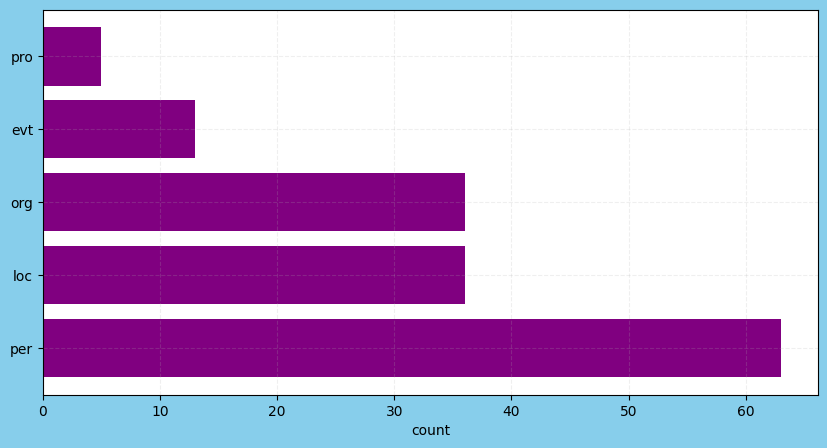

In [61]:
#check for label balance
categories = list(the_dict.keys())
values = list(the_dict.values())
some_figure = plt.figure(figsize = (10,5), facecolor='skyblue')
some_ax = some_figure.add_subplot()
some_ax.grid(linestyle = '--', alpha = 0.2)
some_ax.barh(categories, values, color='purple')
some_ax.set_xlabel('count')

In [ ]:
def score_fn(gold: str, pred: str) -> float:
    metric_score = 0
    #prepare a allowed labels
    allowed_labels = ['loc','org','per','pro','evt']
    #parse golden answer and prediction answer
    gold_parse = [[word.strip() for word in gold_line.split('\t')] for gold_line in gold.split('\n')]
    pred_parse = [[word.strip() for word in gen_line.split(' ') if word.strip() != ''] for gen_line in pred.split('\n')]
    #iterate over parsed lines to find entities
    gold_found = []
    pred_found = []
    #storing labels
    for parsed_pred_line in pred_parse:
        pred_found.append(parsed_pred_line[-2])

    for parsed_gold_line in gold_parse:
        gold_found.append(parsed_gold_line[-2])
        
    for one_label in allowed_labels:
        gold_num = len([item for item in gold_found if item==one_label])
        pred_num = len([item for item in pred_found if item==one_label])
        max_num = max(gold_num,pred_num)
        if max_num != 0:
            metric_score += abs(gold_num-pred_num)/max(gold_num,pred_num)
    return 1-metric_score/len(allowed_labels)

### Задание 6
**Выводы по метрики сагригированной по документам**:
- В среднем количество предсказанных сущностей (определенной метки) отличается в 2 раза от существующих

**Выводы по метрики сагригированной по меткам**:
- Для каждой метки найдется документ, не содержайщий в себе этой метки
- Метка содержащаяся в наименьшим количестве документов являетя pro, в наибольшем -  per
- Количество редких меток модель определяет наиболее точно

In [321]:
#document metric aggregation
lengths_rows = []
metric_rows = []
for row_id in range(len(dataset_with_predictions)):
    #append metric to add to frame
    golden_answer = dataset_with_predictions.iloc[row_id]["golden_answer"]
    prediction = dataset_with_predictions.iloc[row_id]["prediction"]
    metric_rows.append(score_fn(golden_answer, prediction))
    #append legth to add to frame
    the_length = len(dataset_with_predictions.iloc[row_id]["document_text"])
    lengths_rows.append(the_length)

In [326]:
dataset_with_predictions['lengths'] = lengths_rows
dataset_with_predictions['metric'] = metric_rows

In [329]:
sorted_df = dataset_with_predictions.sort_values(by="lengths")
sorted_df

,document_id,document_text,entity,golden_answer,prediction,lengths,metric
4,1002,ru-1002\nru\n2018-07-09\nhttps://echo.msk.ru/n...,"[per, evt, loc, per, org, org, per]",бориса джонсона\tборис джонсон\tper\tper-boris...,тереза мей тереза мэй per per-theresa-may\nпре...,502,0.800000
1,1003,ru-1003\nru\n2018-07-09\nhttps://echo.msk.ru/n...,"[per, loc, loc, per, per, org, per, org, per, ...",борис джонсон\tборис джонсон\tper\tper-boris-j...,борис джонсон борис джонсон per per-boris-john...,557,0.853333
5,1001,ru-1001\nru\n2018-07-09\nhttps://rg.ru/2018/07...,"[org, evt, per, per, loc, per, per, org, org, ...",associated\tpress\torg\torg-the-associated-pre...,борис джонсон борис джонсон per per-boris-john...,775,0.800000
0,1006,ru-1006\nru\n2018-07-09\nhttp://polit.ru/news/...,"[evt, pro, per, per, loc, loc, per, per, per, ...",brexit\tbrexit\tevt\tevt-brexit\nfacebook\tfac...,мария захарова мария захарова per per-maria-za...,905,0.641667
3,1000,ru-1000\nru\n2018-07-09\nhttp://news.meta.ua/u...,"[evt, pro, per, per, per, loc, per, per, org, ...",brexit\tbrexit\tevt\tevt-brexit\nthe guardian\...,борис джонсон борис джонсон per per-boris-john...,1024,0.500000
2,1017,ru-1017\nru\n2018-07-09\nhttp://www.unn.com.ua...,"[evt, pro, per, per, per, per, loc, per, per, ...",brexit\tbrexit\tevt\tevt-brexit\nthe guardian\...,борис джонсон борис джонсон per per-boris-john...,1104,0.508333
7,1004,ru-1004\nru\n2018-07-09\nhttp://www.aif.ru/pol...,"[evt, per, loc, per, per, per, per, org, org, ...",\tbrexit\tevt\tevt-brexit\nборис\tджонсон\tper...,борис джонсон борис джонсон per per-boris-john...,1207,0.757143
6,1011,ru-1011\nru\n2018-07-09\nhttps://tsargrad.tv/n...,"[evt, pro, per, per, per, loc, loc, per, per, ...",brexit\tbrexit\tevt\tevt-brexit\nthe guardian\...,борис джонсон борис джонсон per per-boris-john...,1796,0.440260
8,10,ru-10\nru\n2018-09-20\nhttps://rg.ru/2018/09/2...,"[evt, loc, loc, per, loc, loc, loc, loc, loc, ...",brexit\tbrexit\tevt\tevt-brexit\nальбиона\tаль...,тереза мэй тереза мэй per per-theresa-may\n...,5284,0.434719


In [413]:
#aggregate over labels 
labels = ['loc', 'per', 'org', 'pro', 'evt']
metrics = []

In [414]:
for label in labels:
    for row_id in range(len(sorted_df)):
        pred_num = [[item for item in word.split(' ') if item != ''][-2] for word in re.findall(fr".*?\s{label}\s.*?\n", sorted_df.iloc[row_id]["prediction"])]
        pred_num = len(pred_num)
        gold_num = [[item for item in word.split('\t') if item != ''][-2] for word in re.findall(fr".*?\s{label}\s.*?\n", sorted_df.iloc[row_id]["golden_answer"])]
        gold_num = len(gold_num)
        max_num = max(pred_num, gold_num)
        if max_num != 0:
            metrics.append(abs(pred_num-gold_num)/max(pred_num, gold_num))
        else:
            metrics.append(0)     

Text(0.5, 1.0, 'Document metric aggregation')

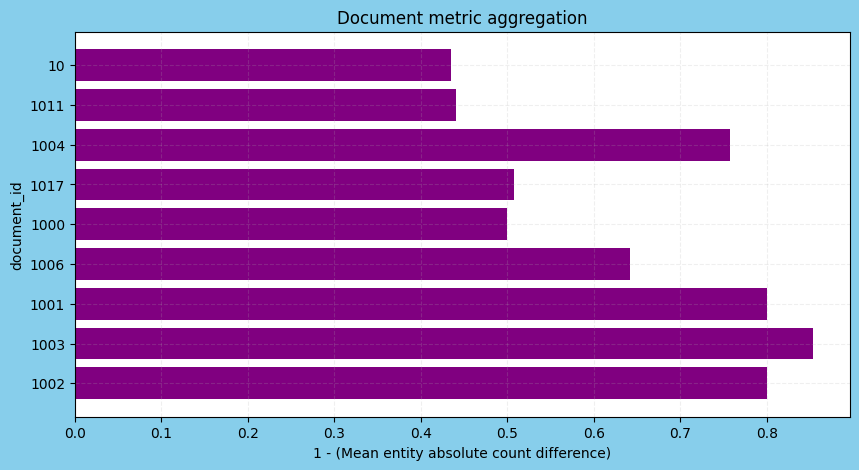

In [355]:
categories = sorted_df["document_id"]
values = sorted_df["metric"]
some_figure = plt.figure(figsize = (10,5), facecolor='skyblue')
some_ax = some_figure.add_subplot()
some_ax.grid(linestyle = '--', alpha = 0.2)
some_ax.barh(categories, values, color='purple')
some_ax.set_xlabel('1 - (Mean entity absolute count difference)')
some_ax.set_ylabel('document_id')
some_ax.set_title("Document metric aggregation")

In [432]:
plot_label_list = []
for label in labels:
    plot_label_list.extend([label]*9)

/tmp/ipykernel_125601/3268930787.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  some_ax.set_yticklabels(labels)


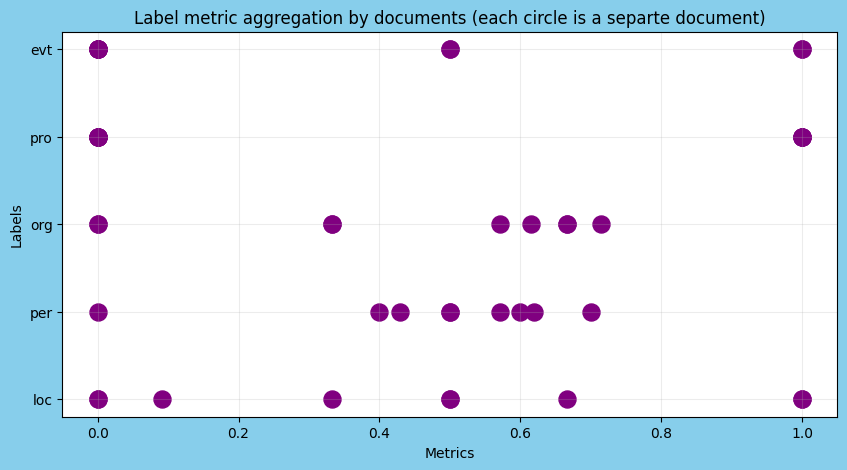

In [446]:
some_figure = plt.figure(figsize = (10,5), facecolor='skyblue')
some_ax = some_figure.add_subplot()
some_ax.set_xlabel('Metrics')
some_ax.set_ylabel('Labels')
some_ax.set_yticklabels(labels)
some_ax.set_title('Label metric aggregation by documents (each circle is a separte document)')
some_ax.scatter(metrics, plot_label_list, color ='purple', s=150)
some_ax.grid(alpha = 0.24)

### Задание 7
При увеличении длины документа в наблюдается уменьшение метрики    
По графику можно визуально предположить, что зависимость экспоненциальное

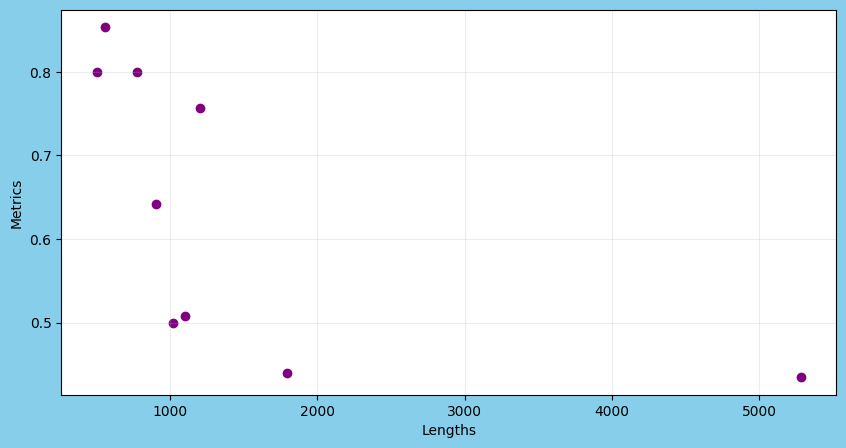

In [345]:
some_figure = plt.figure(figsize = (10,5), facecolor='skyblue')
some_ax = some_figure.add_subplot()
some_ax.scatter(sorted_df['lengths'], sorted_df['metric'], color ='purple')
some_ax.set_xlabel('Lengths')
some_ax.set_ylabel('Metrics')
some_ax.grid(alpha = 0.24)

### Задание 8 

**Повышение метрик**
- Оптимизация промпта (больше примеров и указаний)
- Подключение к базе знаний с качественными примерами, подходящими под конкретные документы (семантический поиск)
- Для таких задач как NER значительное улучшение может дать fine-tuning 

**Предсказания**
- Лучше всего модель распознает per (имена, фамили, имена и фамилии находятся легко)
- Хуже всего модель распознает loc (путаница с организациями)

### Задание 9

**Основные выводы**
1. Влияние длины промпта на качество инструкционного следования. Увеличение длины промпта негативно влияет на способность модели корректно следовать заданным инструкциям: чем больше вводимый контекст, тем выше вероятность отклонений от требуемого формата.    
2. Рост количества нерелевантных сущностей при увеличении размера документа.    
При обработке более длинных документов модель начинает извлекать лишние, не относящиеся к задаче сущности, что снижает точность итоговой разметки.
3. Наличие галлюцинаций меток. Модель демонстрирует склонность к генерации галлюцинаций, присваивает сущностям некорректные или вымышленные метоки

**Новые знания**
- GigaChat имеет контекстное окно в 8000 токенов